# Object measurements and quantifications

Processing operations are usually part of an analysis pipeline where the end goal if often to measure and extract quantifications from the data. In this section, we will see how to extract measurements from segmented objects.

Let's first re-apply some processing and get an image segmented, ready to be quantified.

In [50]:
import pyclesperanto_prototype as cle
import numpy as np
import pandas as pd
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
cle.select_device('TX')  # TODO: change to your GPU

<NVIDIA GeForce RTX 2080 SUPER on Platform: NVIDIA CUDA (2 refs)>

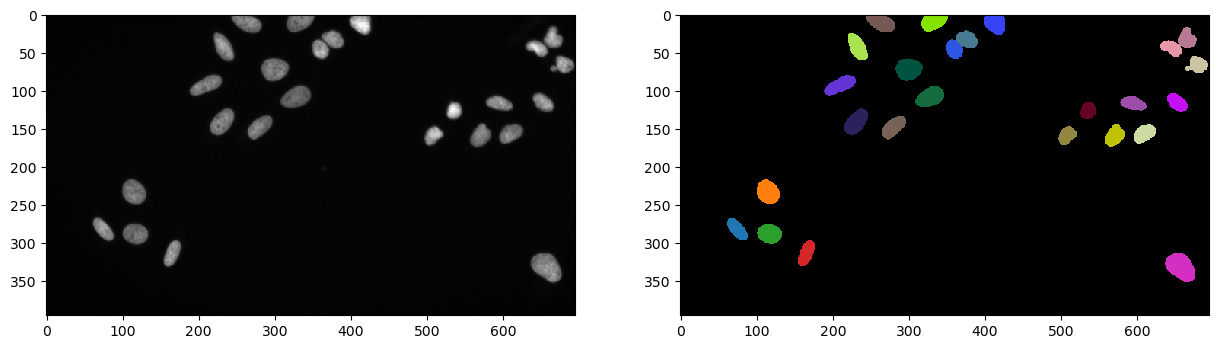

In [51]:
image = imread("../../data/IXMtest_A02_s9.tif")[:,:,0]
segmentation = cle.voronoi_otsu_labeling(image, spot_sigma=5, outline_sigma=1)
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(image, plot=axs[0])
cle.imshow(segmentation, labels=True, plot=axs[1])

We have now image with various nuclei that we can count and measure some properties from.

In [52]:
print("there is",segmentation.max(),"objects in the image")

there is 25.0 objects in the image


However, it is not advised to keep object at the image border for further quantifications.

there is 22.0 objects in the image


cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
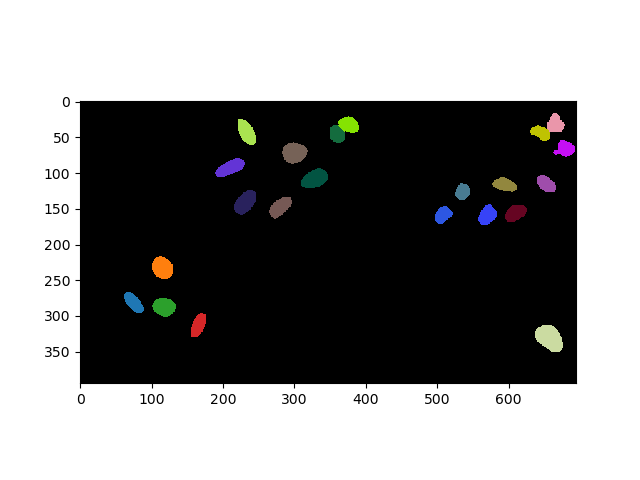

In [53]:
final = cle.exclude_labels_on_edges(segmentation)
print("there is",final.max(),"objects in the image")
final

The number of objects is a nice thing to know, but clearly not sufficient to describe the content of an image and the objects in it. We therefore need to measure more properties. 

The first approach to do so is using the `statistics_of_labelled_pixels` function. This function will compute a series of features and return it as a dictionary.

In [54]:
stats = cle.statistics_of_labelled_pixels(image, final)
stats.keys()

dict_keys(['label', 'original_label', 'bbox_min_x', 'bbox_min_y', 'bbox_min_z', 'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_width', 'bbox_height', 'bbox_depth', 'min_intensity', 'max_intensity', 'sum_intensity', 'area', 'mean_intensity', 'sum_intensity_times_x', 'mass_center_x', 'sum_intensity_times_y', 'mass_center_y', 'sum_intensity_times_z', 'mass_center_z', 'sum_x', 'centroid_x', 'sum_y', 'centroid_y', 'sum_z', 'centroid_z', 'sum_distance_to_centroid', 'mean_distance_to_centroid', 'sum_distance_to_mass_center', 'mean_distance_to_mass_center', 'standard_deviation_intensity', 'max_distance_to_centroid', 'max_distance_to_mass_center', 'mean_max_distance_to_centroid_ratio', 'mean_max_distance_to_mass_center_ratio'])

The results can then be processed and analysed using the Python package [pandas](https://pandas.pydata.org/).

In [55]:
df = pd.DataFrame(stats)
df.head()

,label,original_label,bbox_min_x,bbox_min_y,bbox_min_z,bbox_max_x,bbox_max_y,bbox_max_z,bbox_width,bbox_height,...,centroid_z,sum_distance_to_centroid,mean_distance_to_centroid,sum_distance_to_mass_center,mean_distance_to_mass_center,standard_deviation_intensity,max_distance_to_centroid,max_distance_to_mass_center,mean_max_distance_to_centroid_ratio,mean_max_distance_to_mass_center_ratio
0,1,1,62.0,268.0,0.0,88.0,296.0,0.0,27.0,29.0,...,0.0,4595.551758,9.228016,4595.617676,9.228148,117.789139,17.876007,17.941978,1.937145,1.944266
1,2,2,101.0,217.0,0.0,130.0,248.0,0.0,30.0,32.0,...,0.0,7813.088867,10.389746,7814.160156,10.391171,73.591118,17.053759,17.259949,1.641403,1.661021
2,3,3,101.0,276.0,0.0,133.0,301.0,0.0,33.0,26.0,...,0.0,6532.061035,9.822648,6533.275879,9.824475,62.050163,16.461588,16.716045,1.675881,1.701470
3,4,4,155.0,297.0,0.0,176.0,330.0,0.0,22.0,34.0,...,0.0,4903.900879,9.485302,4904.504395,9.486469,116.971138,18.448812,18.383656,1.944989,1.937882
4,5,5,189.0,80.0,0.0,230.0,106.0,0.0,42.0,27.0,...,0.0,7612.879883,11.295074,7613.652832,11.296221,84.454979,22.714182,22.619347,2.010981,2.002382


#### More measurements

Not all features are available. We are still missing some, especially shape descriptors. But it is important to say here that they do not all easy to to be computed by a GPU.

For the time behing, we made the `regionprops` function, from the scikit-image, compatible with `pyclesperanto`. The usage and return values are the same as the original function. And the function still rely on CPU for the computation.

In [56]:
props = cle.regionprops(final, image)

The properties list name can be found at the [scikit-image documentation](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops).

In [59]:
props_list = ['label', 'area', 'solidity', 'perimeter']
for l in range(0, int(final.max())):
    print(["{0}: {1}".format(p, getattr(props[l], p)) for p in props_list])

['label: 1', 'area: 498.0', 'solidity: 0.9669902912621359', 'perimeter: 88.08326112068524']
['label: 2', 'area: 752.0', 'solidity: 0.9766233766233766', 'perimeter: 100.08326112068524']
['label: 3', 'area: 665.0', 'solidity: 0.9765051395007343', 'perimeter: 94.66904755831213']
['label: 4', 'area: 517.0', 'solidity: 0.9681647940074907', 'perimeter: 91.01219330881976']
['label: 5', 'area: 674.0', 'solidity: 0.9533239038189534', 'perimeter: 109.9827560572969']
['label: 6', 'area: 736.0', 'solidity: 0.9722589167767504', 'perimeter: 103.98275605729688']
['label: 7', 'area: 638.0', 'solidity: 0.9710806697108066', 'perimeter: 100.66904755831213']
['label: 8', 'area: 619.0', 'solidity: 0.9717425431711146', 'perimeter: 97.39696961966999']
['label: 9', 'area: 805.0', 'solidity: 0.9663865546218487', 'perimeter: 105.74011537017762']
['label: 10', 'area: 769.0', 'solidity: 0.9746514575411914', 'perimeter: 105.74011537017762']
['label: 11', 'area: 433.0', 'solidity: 0.9796380090497737', 'perimeter: 7